# Stochastic processes simulation and calibration

In [ ]:
# install qftools from github
%pip install git+https://github.com/akaufman22/qftools.git

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib.pyplot as plt

from qftools import (
    generate_bm,
    generate_gbm,
    ctc_vol,
    parkinson,
    garman_klass,
    yang_zhang,
    rodgers_satchell
)

plt.style.use("ggplot")

## Brownian Motion process
### Definition
SDE is given by
$$
dX_t = \mu dt + \sigma dW_t
$$
where $W_t$ is a Wiener process. The solution is given by
$$
X_t = X_0 + \mu t + \sigma W_t
$$
where $W_t$ is a standard Brownian motion. The process is a continuous-time analogue of a random walk. The process is Markovian, and has stationary and independent increments.

### Simulation of single path

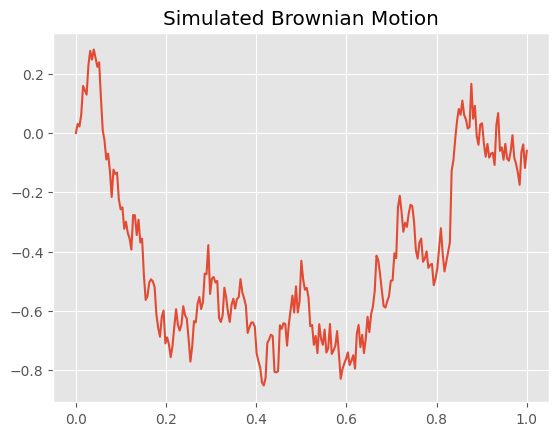

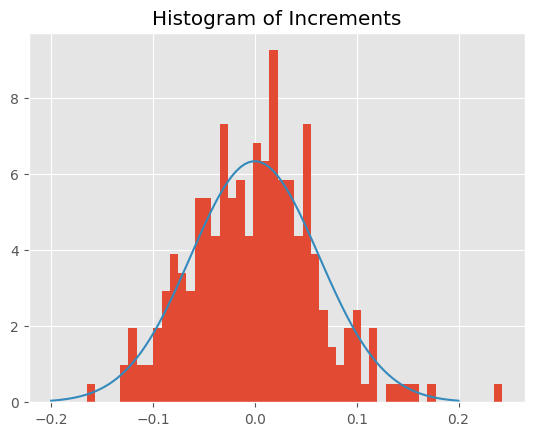

Estimated drift:   -0.0598 Estimated vol:    0.9653
Theoretical drift:  0.0000 Theoretical vol:  1.0000


In [2]:
simulation = generate_bm(1,252,1,random_state=42).reshape(-1,1)
theo_dist = scs.norm.pdf(np.linspace(-0.2,0.2,100), 0, np.sqrt(1/252))
plt.plot(np.linspace(0,1,253),simulation)
plt.title("Simulated Brownian Motion")
plt.show()
increments = np.diff(simulation, axis=0).reshape(-1)
plt.hist(increments, density=True, bins=50)
plt.title("Histogram of Increments")
plt.plot(np.linspace(-0.2,0.2,100),theo_dist)
plt.show()
print(f'Estimated drift:   {252*increments.mean(): 05.4f} Estimated vol:   {np.sqrt(252)*increments.std(): 05.4f}')
print(f'Theoretical drift: {0: 05.4f} Theoretical vol: {1: 05.4f}')


### Simulation of multiple paths
Distribution of $X_t$ is given by
$$
X_t \sim N(X_0 + \mu t, \sigma^2 t)
$$

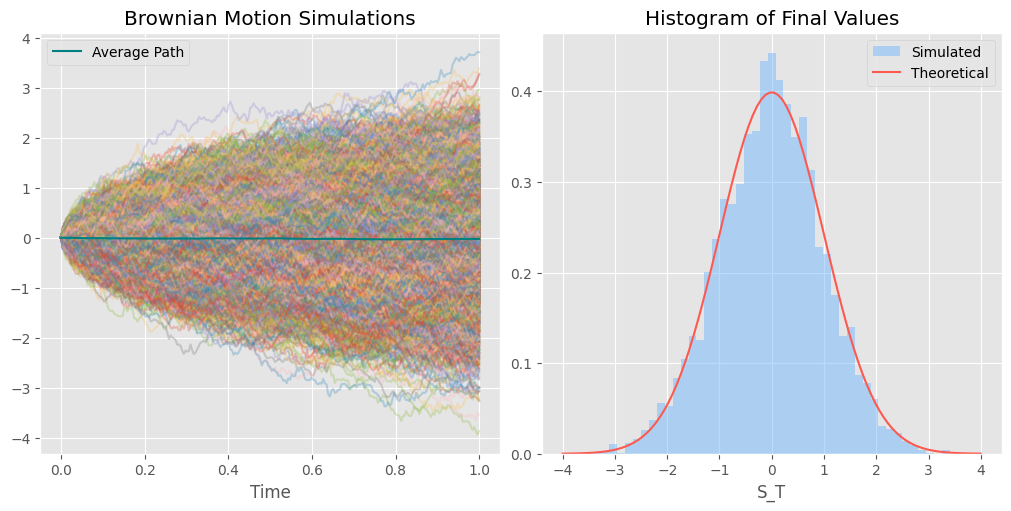

Final Values Mean: -0.0227, Std:  0.9956
Theoretical Mean:   0.0000, Std:  1.0000


In [3]:
simulations = generate_bm(1, 252, 5000, random_state=42).T

theo_dist = scs.norm.pdf(np.linspace(-4,4,100), 0, 1)
avg_path = simulations.mean(axis=1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
ax[0].plot(np.linspace(0,1,253), simulations, alpha=0.3)
ax[0].plot(np.linspace(0,1,253), avg_path, color='teal', label='Average Path')
ax[0].set_title('Brownian Motion Simulations')
ax[0].set_xlabel('Time')
ax[0].legend()
ax[1].hist(simulations[-1], bins=50, alpha=0.5, density=True, facecolor='xkcd:sky blue', label='Simulated')
ax[1].plot(np.linspace(-4,4,100), theo_dist, label='Theoretical', color='xkcd:coral')
ax[1].set_title('Histogram of Final Values')
ax[1].set_xlabel('S_T')
ax[1].legend()
plt.show()
print(f'Final Values Mean: {np.mean(simulations[-1]): 05.4f}, Std: {np.std(simulations[-1]): 05.4f}')
print(f'Theoretical Mean:  {0: 05.4f}, Std: {1: 05.4f}')

## Geometric Brownian Motion
### Definition
SDE is given by
$$
dX_t = \mu X_t dt + \sigma X_t dW_t
$$
where $W_t$ is a Wiener process. The solution is given by
$$
X_t = X_0 \exp\left(\left(\mu - \frac{1}{2}\sigma^2\right)t + \sigma W_t\right)
$$

### Simulation of single path

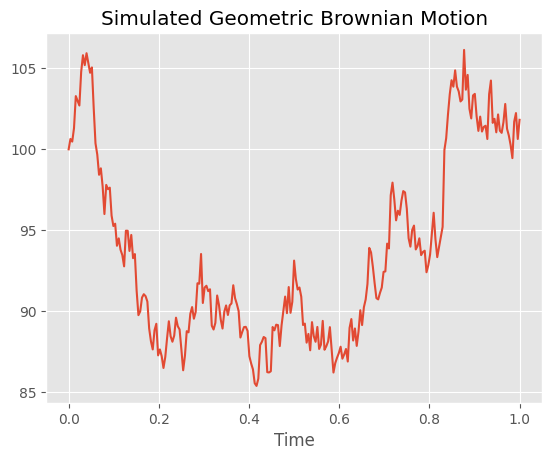

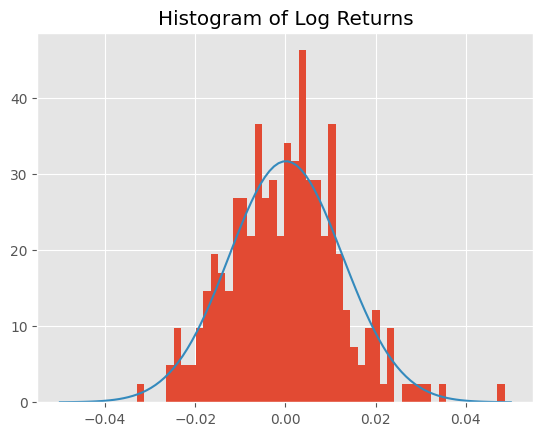

Ann log return          0.02, Ann Volatility          0.19
Theoretical log return  0.03, Theoretical Volatility  0.20


In [4]:
T = 1
N = 252
r = 0.05
sigma = 0.2
S_0 = 100

simulation = generate_gbm(T,N,r,  sigma, S_0, 1,random_state=42).reshape(-1)
theo_dist = scs.norm.pdf(np.linspace(-0.05, 0.05, 100), (r - 0.5*sigma**2)/N, sigma/np.sqrt(N))
plt.plot(np.linspace(0,T,N+1),simulation)
plt.title("Simulated Geometric Brownian Motion")
plt.xlabel("Time")
plt.show()

log_returns = np.log(simulation[1:]/simulation[:-1])
plt.hist(log_returns, bins=50, density=True)
plt.plot(np.linspace(-0.05,0.05,100), theo_dist)
plt.title("Histogram of Log Returns")
plt.show()
print(f'Ann log return         {N*log_returns.mean(): 05.2f}, Ann Volatility         {np.sqrt(N)*log_returns.std(): 05.2f}')
print(f'Theoretical log return {r - 0.5*sigma**2: 05.2f}, Theoretical Volatility {sigma: 05.2f}')


### Simulation of multiple paths
Probability density function of Geometric Brownian Motion is given by
$$
f(x, t) = \frac{1}{\sqrt{2\pi \sigma^2 t}} \exp\left(-\frac{(\log(x) - (\mu - \frac{1}{2}\sigma^2)t)^2}{2\sigma^2 t}\right)
$$
Expected value of Geometric Brownian Motion is given by
$$
E[X_t] = X_0 \exp(\mu t)
$$
Variance of Geometric Brownian Motion is given by
$$
Var[X_t] = X_0^2 \exp(2\mu t)(\exp(\sigma^2 t) - 1)
$$

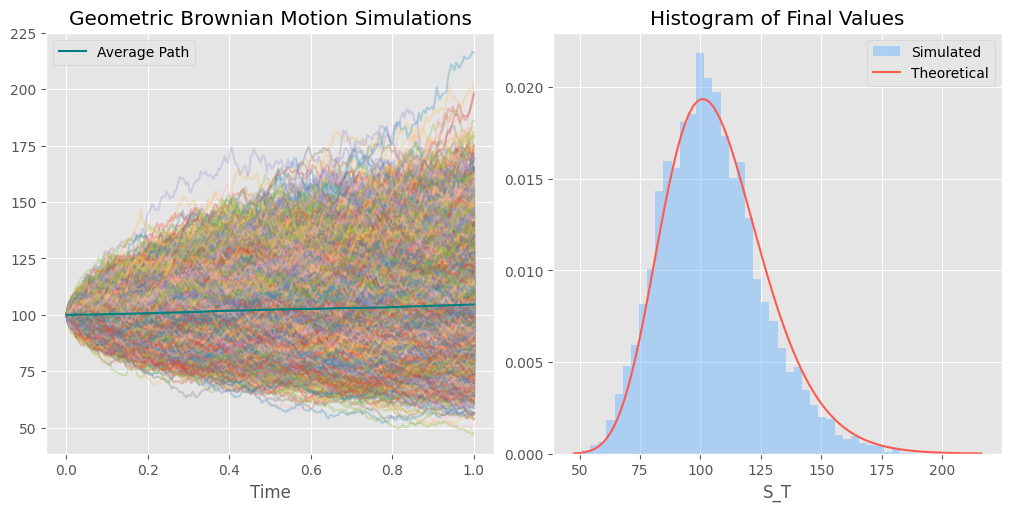

Final Values Mean:  104.62, Std:  20.94
Theoretical Mean:   105.13, Std:  21.24


In [5]:
k = 5000

simulations = generate_gbm(T, N, r, sigma, S_0, k, random_state=42).T
average_path = simulations.mean(axis=1)

theo_mean = S_0*np.exp(r*T)
theo_std = S_0*np.exp(r*T)*np.sqrt(np.exp(T*sigma**2)-1)
theo_s = (np.log((theo_mean ** 2 + theo_std ** 2) / theo_mean ** 2)) ** 0.5
x = np.linspace(simulations[-1].min(), simulations[-1].max(), 100)
theo_dist = scs.lognorm.pdf(x=x, scale=theo_mean, s=theo_s)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
ax[0].plot(np.linspace(0,T,N+1), simulations, alpha=0.3)
ax[0].plot(np.linspace(0,T,N+1), average_path, color='teal', label='Average Path')
ax[0].set_title('Geometric Brownian Motion Simulations')
ax[0].set_xlabel('Time')
ax[0].legend()
ax[1].hist(simulations[-1], bins=50, alpha=0.5, density=True, facecolor='xkcd:sky blue', label='Simulated')
ax[1].plot(x, theo_dist, label='Theoretical', color='xkcd:coral')
ax[1].set_title('Histogram of Final Values')
ax[1].set_xlabel('S_T')                         
ax[1].legend()
plt.show()
print(f'Final Values Mean: {np.mean(simulations[-1]): 05.2f}, Std: {np.std(simulations[-1]): 05.2f}')
print(f'Theoretical Mean:  {theo_mean: 05.2f}, Std: {theo_std: 05.2f}')

## Volatility estimates

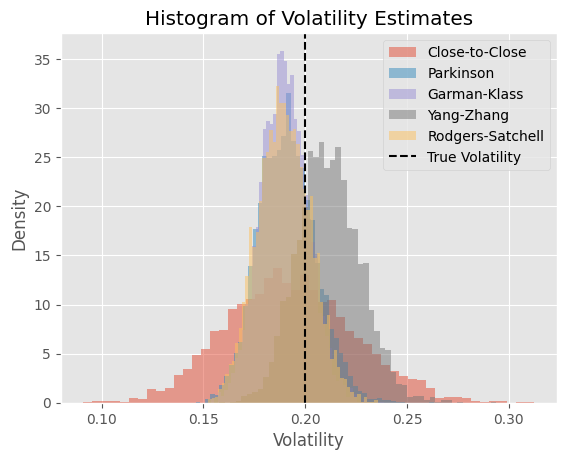

,Mean,Std
Estimator,,
Close-to-Close,0.1927,0.0313
Parkinson,0.1911,0.0141
Garman-Klass,0.1898,0.0115
Yang-Zhang,0.2118,0.0155
Rodgers-Satchell,0.1896,0.0128


In [6]:
T = 1 / 12
N = 21 * 24 * 60
r = 0.05
sigma = 0.2
S_0 = 100
k = 5000

simulations = generate_gbm(T, N, r, sigma, S_0, k, random_state=42).T

df_sim = pd.DataFrame(data=simulations, index=pd.date_range(start='2025-01-01', periods=N+1, freq='T'),
                    columns=np.arange(k))

vol_ctc = np.array([])
vol_parkinson = np.array([])
vol_garman_klass = np.array([])
vol_yang_zhang = np.array([])
vol_rodgers_satchell = np.array([])
#df_ohlc = df_sim.between_time('00:00', '18:00').resample('D').ohlc()
df_ohlc = df_sim.resample('D').ohlc()
df_ohlc.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)
for i in range(k):
    df = df_ohlc[i].copy()
    df.loc[:, 'Adj Close'] = df['Close']
    vol_ctc = np.append(vol_ctc, ctc_vol(df, 21, ddof=1).iloc[-1])
    vol_parkinson = np.append(vol_parkinson, parkinson(df, 21).iloc[-1])
    vol_garman_klass = np.append(vol_garman_klass, garman_klass(df, 21).iloc[-1])
    vol_yang_zhang = np.append(vol_yang_zhang, yang_zhang(df, 21).iloc[-1])
    vol_rodgers_satchell = np.append(vol_rodgers_satchell, rodgers_satchell(df, 21).iloc[-1])
plt.hist(vol_ctc, bins=50, alpha=0.5, density=True, label='Close-to-Close')
plt.hist(vol_parkinson, bins=50, alpha=0.5, density=True, label='Parkinson')
plt.hist(vol_garman_klass, bins=50, alpha=0.5, density=True, label='Garman-Klass')
plt.hist(vol_yang_zhang, bins=50, alpha=0.5, density=True, label='Yang-Zhang')
plt.hist(vol_rodgers_satchell, bins=50, alpha=0.5, density=True, label='Rodgers-Satchell')
plt.axvline(sigma, color='black', linestyle='--', label='True Volatility')
plt.title('Histogram of Volatility Estimates')
plt.xlabel('Volatility')
plt.ylabel('Density')
plt.legend()
plt.show()

df_estimates = pd.DataFrame(index=['Close-to-Close', 'Parkinson', 'Garman-Klass', 'Yang-Zhang', 'Rodgers-Satchell'],
                            columns=['Mean', 'Std'])
df_estimates.index.name = 'Estimator'
for e in zip([vol_ctc, vol_parkinson, vol_garman_klass, vol_yang_zhang, vol_rodgers_satchell], df_estimates.index):
    df_estimates.loc[e[1], 'Mean'] = e[0].mean()
    df_estimates.loc[e[1], 'Std'] = e[0].std()
display(df_estimates.style.format('{:.4f}'))


### Rolling Volatility estimates for single path

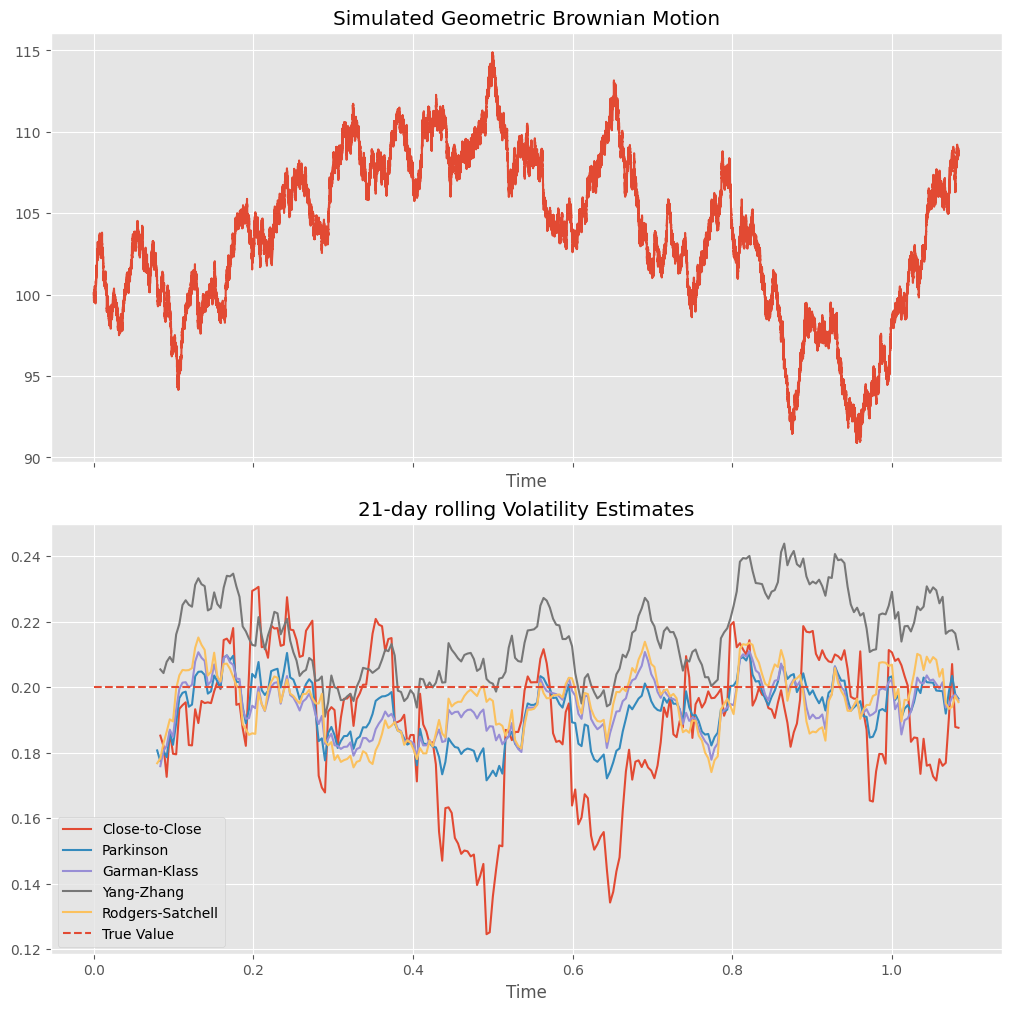

In [2]:
T = 1 + 1/12
N = int(T * 252 * 24 * 60)
r = 0.05
sigma = 0.2
S_0 = 100
k = 5000
simulation = generate_gbm(T, N, r, sigma, S_0, 1, random_state=42).T

df_sim = pd.DataFrame(data=simulation, index=pd.date_range(start='2025-01-01', periods=N+1, freq='T'), columns=['Price'])
df_ohlc = df_sim.resample('D')['Price'].ohlc()
df_ohlc.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)
#df_ohlc.columns = df_ohlc.columns.get_level_values(1)
df_ohlc['Adj Close'] = df_ohlc['Close']
total_days = df_ohlc.shape[0]
vol_ctc = ctc_vol(df_ohlc, 21, ddof=1).to_numpy()
vol_parkinson = parkinson(df_ohlc, 21).to_numpy()
vol_garman_klass = garman_klass(df_ohlc, 21).to_numpy()
vol_yang_zhang = yang_zhang(df_ohlc, 21).to_numpy()
vol_rodgers_satchell = rodgers_satchell(df_ohlc, 21).to_numpy()
x = np.linspace(0, T, total_days)
xx = np.linspace(0, T, N+1)
fig, ax = plt.subplots(2, 1, figsize=(10, 10), constrained_layout=True, sharex=True)
ax[0].plot(xx, simulation)
ax[0].set_title('Simulated Geometric Brownian Motion')
ax[0].set_xlabel('Time')
ax[1].plot(x, vol_ctc, label='Close-to-Close')
ax[1].plot(x, vol_parkinson, label='Parkinson')
ax[1].plot(x, vol_garman_klass, label='Garman-Klass')
ax[1].plot(x, vol_yang_zhang, label='Yang-Zhang')
ax[1].plot(x, vol_rodgers_satchell, label='Rodgers-Satchell')
ax[1].hlines(sigma, 0, T, linestyles='dashed', label='True Value')
ax[1].set_title('21-day rolling Volatility Estimates')
ax[1].set_xlabel('Time')
ax[1].legend()
plt.show()